In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('div.output_stderr').hide();
 } else {
 $('div.input').show();
 $('div.output_stderr').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action='javascript:code_toggle()'><input STYLE='color: #4286f4' type='submit' value='Click here to toggle on/off the raw code.'></form>''')

# Purpose
This notebook is for the spectral analysis with our confidence of the ripple state classification >= 0.7.

In [2]:
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr

from src.data_processing import read_netcdfs

import warnings
warnings.filterwarnings('ignore', 'numpy equal will not check object identity in the future')

In [5]:
def plot_coherence(path, group, brain_area1, brain_area2, frequency, figsize=(15, 5)):
    transform_func = lambda ds: ds.sel(
        tetrode1=ds.tetrode1[ds.brain_area1==brain_area1],
        tetrode2=ds.tetrode2[ds.brain_area2==brain_area2],
        frequency=frequency
    )
    ds = read_netcdfs(
        path, dim='session', group=group,
        transform_func=transform_func).coherence_magnitude
    
    mean_dims = ['session', 'tetrode1', 'tetrode2']
    baseline = ds.isel(time=0).mean(mean_dims)
    baseline_lower_ci = ds.isel(time=0).quantile(0.025, mean_dims)
    baseline_upper_ci = ds.isel(time=0).quantile(0.975, mean_dims)
    raw_measure = ds.mean(mean_dims)
    diff_from_baseline = (ds - ds.isel(time=0)).mean(mean_dims)

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    baseline.plot(ax=axes[0], color='blue', linestyle='-', linewidth=3);
    baseline_lower_ci.plot(ax=axes[0], color='blue', linestyle='--', linewidth=1);
    baseline_upper_ci.plot(ax=axes[0], color='blue', linestyle='--', linewidth=1);
    axes[0].set_title('Baseline Coherence')
    raw_measure.plot(x='time', y='frequency', ax=axes[1]);
    axes[1].set_title('Raw coherence')
    diff_from_baseline.plot(
        x='time', y='frequency', ax=axes[2], center=0);
    axes[2].set_title('Difference from baseline coherence')
    
    for ax in axes[1:]:
        ax.axvline(0, color='black', linestyle='--')
    
    plt.tight_layout()
    plt.suptitle(
        '{brain_area1} - {brain_area2}'.format(
            brain_area1=brain_area1, brain_area2=brain_area2),
        fontsize=18, fontweight='bold')
    plt.subplots_adjust(top=0.85)

In [8]:
def plot_coherence_by_ripple_type(path, brain_area1, brain_area2, frequency,
                                  resolution, covariate, level1, level2,
                                  figsize=(15, 5)):
    def get_data(level):
        group = '{resolution}/{covariate}/{level}/coherence_magnitude'.format(
            resolution=resolution, covariate=covariate, level=level)
        transform_func = lambda ds: ds.sel(
            tetrode1=ds.tetrode1[ds.brain_area1==brain_area1],
            tetrode2=ds.tetrode2[ds.brain_area2==brain_area2],
            frequency=frequency
        )
        return read_netcdfs(
            path, dim='session', group=group,
            transform_func=transform_func).coherence_magnitude
    
    ds1 = get_data(level1)
    ds2 = get_data(level2)
    
    mean_dims = ['session', 'tetrode1', 'tetrode2']
    ds_level1 = ds1.mean(mean_dims)
    ds_level2 = ds2.mean(mean_dims)
    ds_level2_level1 = (ds2 - ds1).mean(mean_dims)

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    ds_level1.plot(x='time', y='frequency', ax=axes[0], cmap='Purples');
    axes[0].set_title(level1)
    ds_level2.plot(x='time', y='frequency', ax=axes[1], cmap='Greens');
    axes[1].set_title(level2)
    ds_level2_level1.plot(
        x='time', y='frequency', ax=axes[2], cmap='PRGn', center=0);
    axes[2].set_title(
        '{covariate}: {level2} - {level1}'.format(
            level1=level1,
            level2=level2,
            covariate=covariate
        )
    )
    
    for ax in axes:
        ax.axvline(0, color='black', linestyle='--')
    
    plt.tight_layout()
    plt.suptitle(
        '{brain_area1} - {brain_area2}'.format(
            brain_area1=brain_area1, brain_area2=brain_area2),
        fontsize=18, fontweight='bold')
    plt.subplots_adjust(top=0.85)

## All Ripples

### Low Frequencies

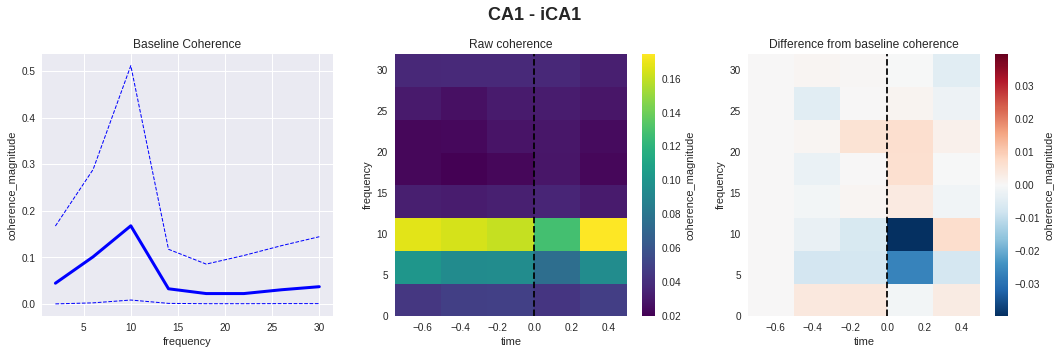

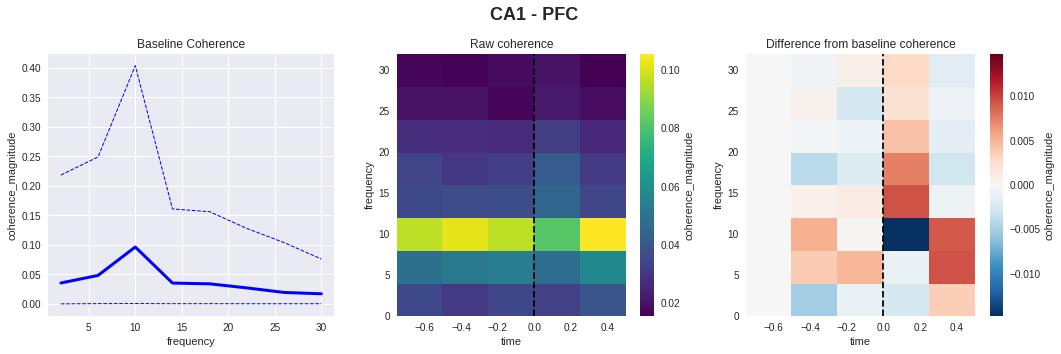

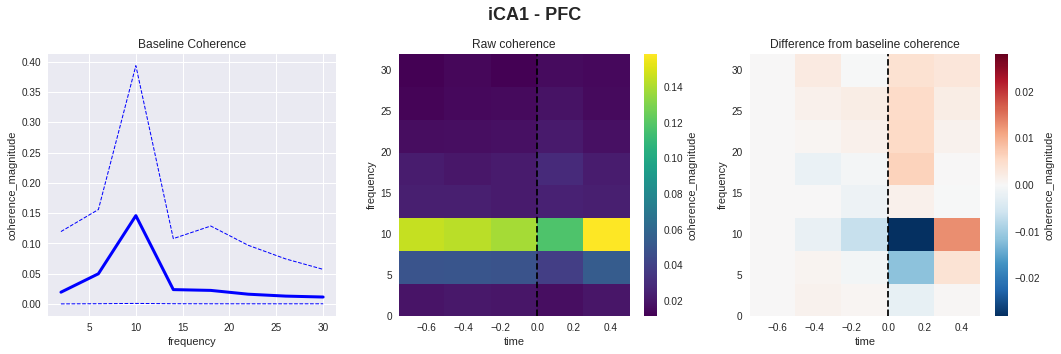

In [6]:
path = '../Processed-Data/*.nc'
group = '4Hz_Resolution/all_ripples/coherence_magnitude'
frequency = slice(0, 30)

brain_areas = ['CA1', 'iCA1', 'PFC']
for brain_area1, brain_area2 in combinations(brain_areas, 2):
    plot_coherence(path, group, brain_area1, brain_area2, frequency)

### Gamma Frequencies

#### 4 Hz Frequency Resolution

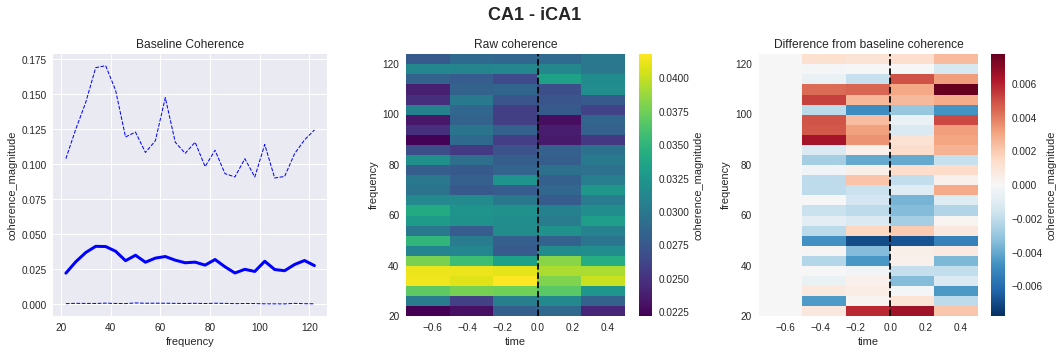

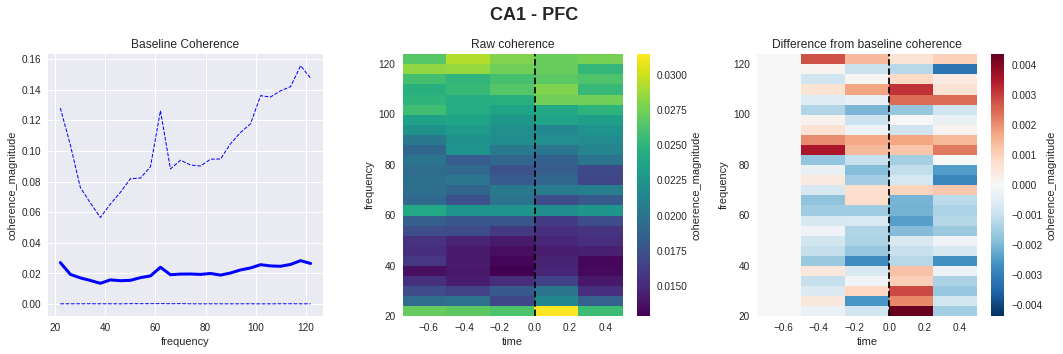

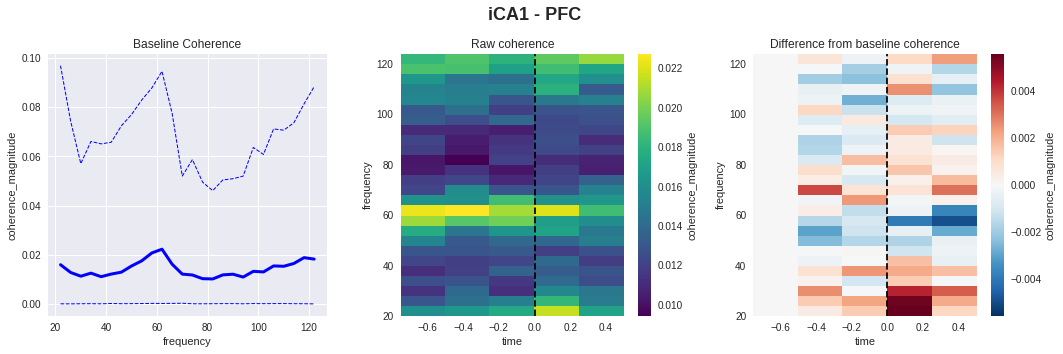

In [7]:
path = '../Processed-Data/*.nc'
group = '4Hz_Resolution/all_ripples/coherence_magnitude'

frequency = slice(20, 125)
brain_areas = ['CA1', 'iCA1', 'PFC']
for brain_area1, brain_area2 in combinations(brain_areas, 2):
    plot_coherence(path, group, brain_area1, brain_area2, frequency)

#### 10 Hz Frequency Resolution

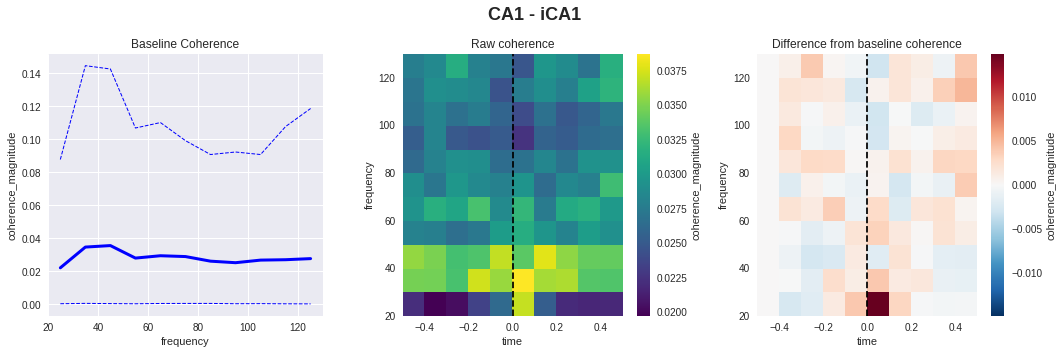

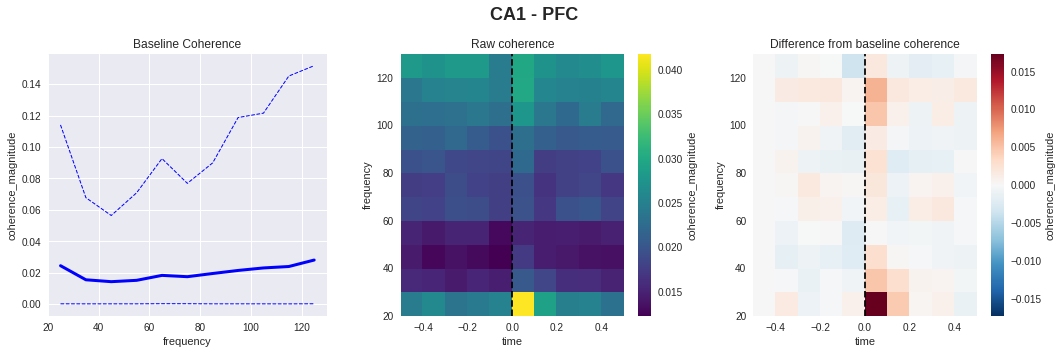

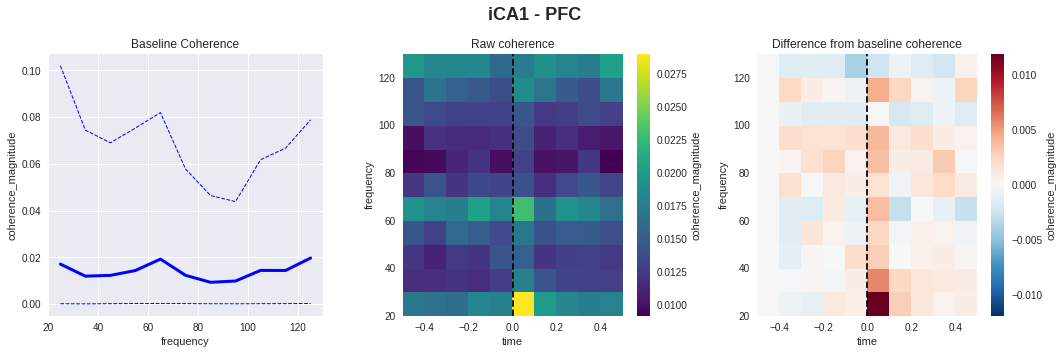

In [8]:
path = '../Processed-Data/*.nc'
group = '10Hz_Resolution/all_ripples/coherence_magnitude'

frequency = slice(20, 125)
brain_areas = ['CA1', 'iCA1', 'PFC']
for brain_area1, brain_area2 in combinations(brain_areas, 2):
    plot_coherence(path, group, brain_area1, brain_area2, frequency)

### Ripple Frequencies

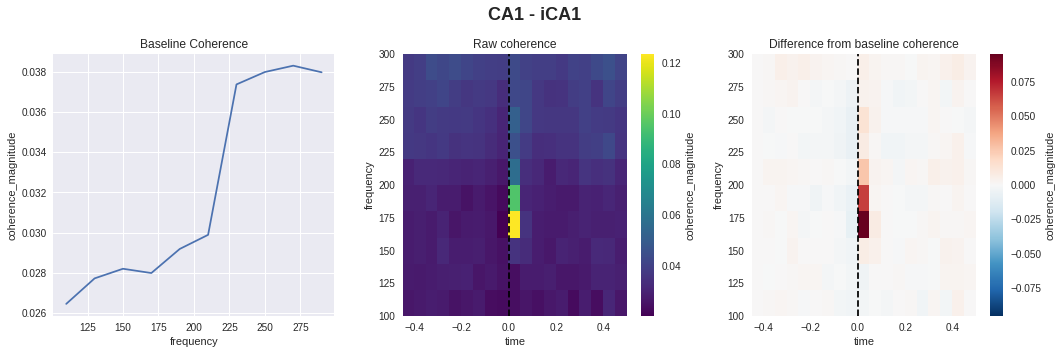

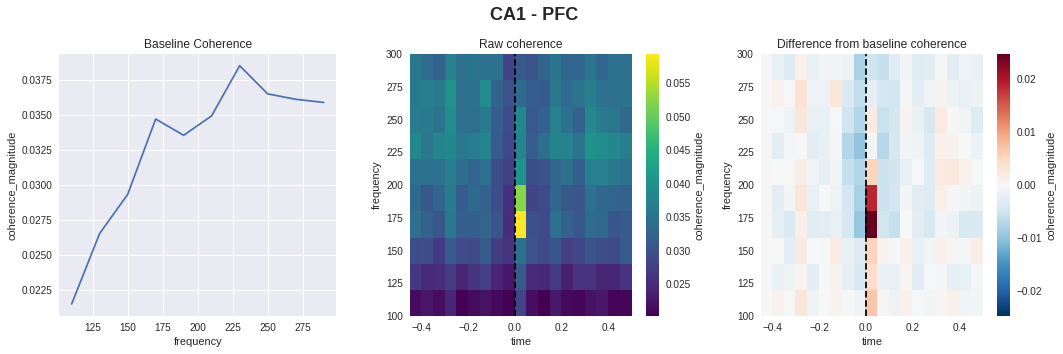

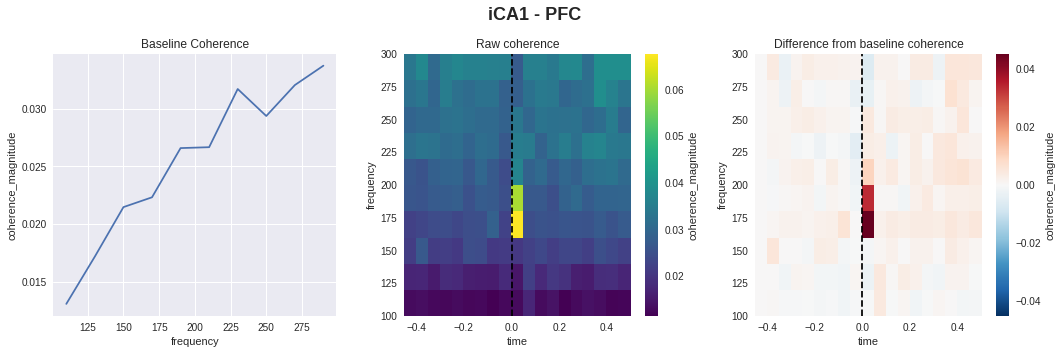

In [9]:
path = '../Processed-Data/*.nc'
group = '20Hz_Resolution/all_ripples/coherence_magnitude'

frequency = slice(100, 300)
brain_areas = ['CA1', 'iCA1', 'PFC']
for brain_area1, brain_area2 in combinations(brain_areas, 2):
    plot_coherence(path, group, brain_area1, brain_area2, frequency)

## Ripple Direction: Forward vs. Reverse

### Low Frequencies

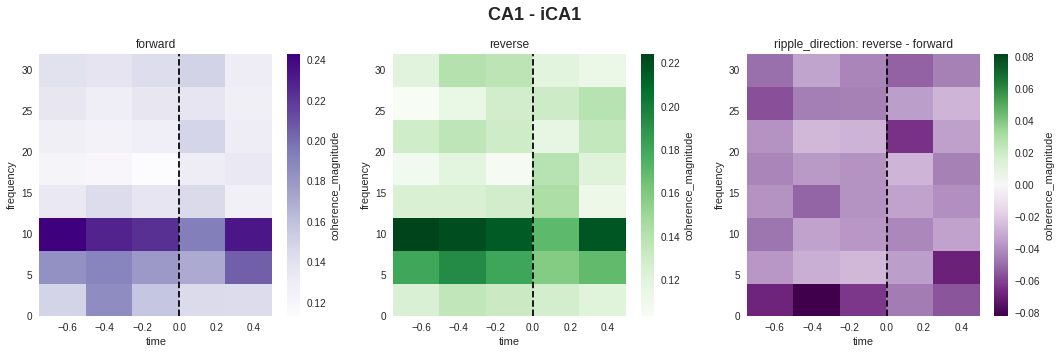

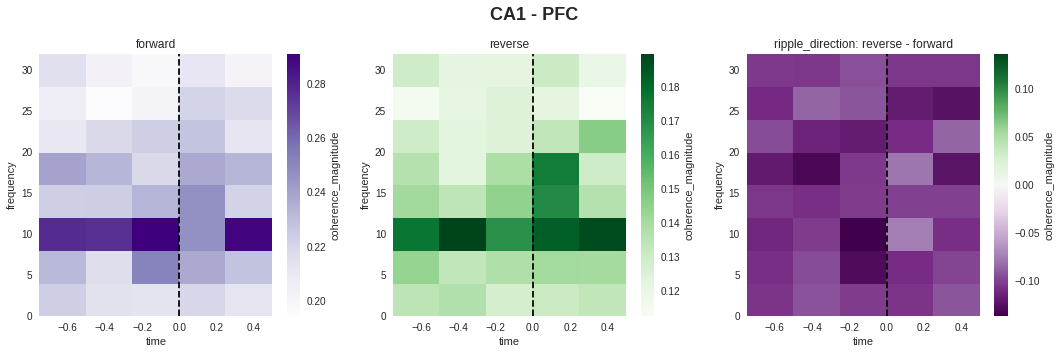

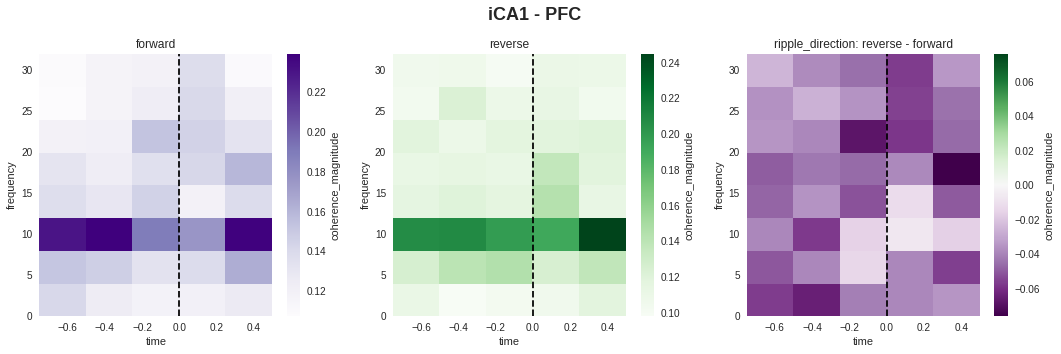

In [10]:
path = '../Processed-Data/*.nc'
covariate = 'ripple_direction'
level1 = 'forward'
level2 = 'reverse'
resolution = '4Hz_Resolution'
frequency = slice(0, 30)

brain_areas = ['CA1', 'iCA1', 'PFC']
for brain_area1, brain_area2 in combinations(brain_areas, 2):
    plot_coherence_by_ripple_type(path, brain_area1, brain_area2, frequency,
                                  resolution, covariate, level1, level2)

### Gamma Frequencies

#### 4 Hz Frequency Resolution

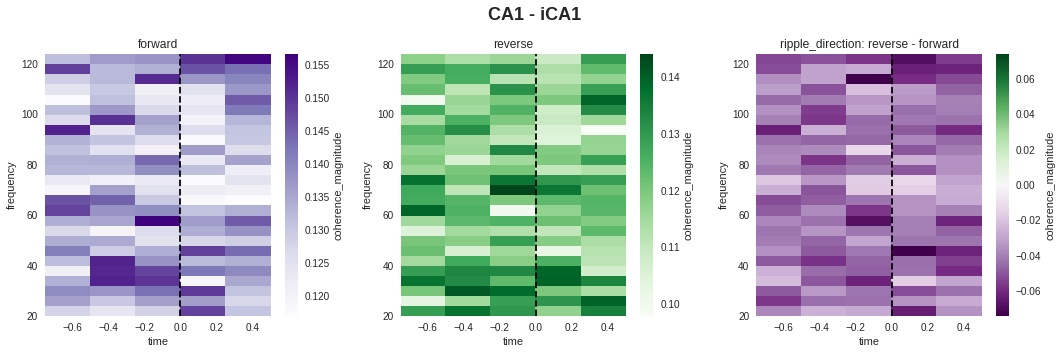

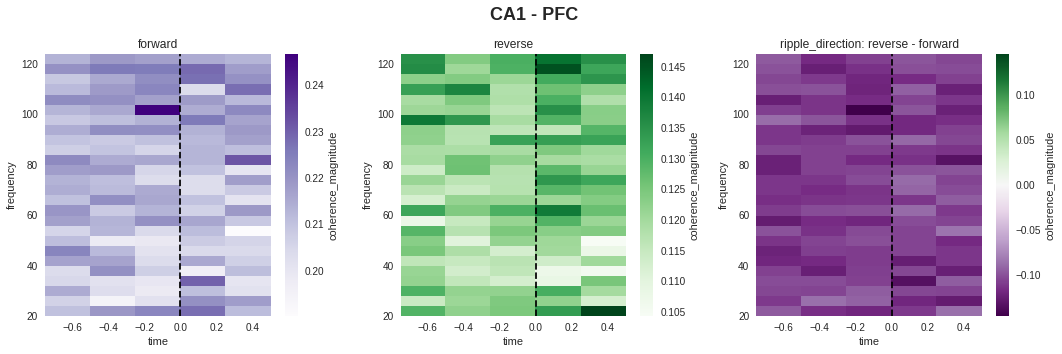

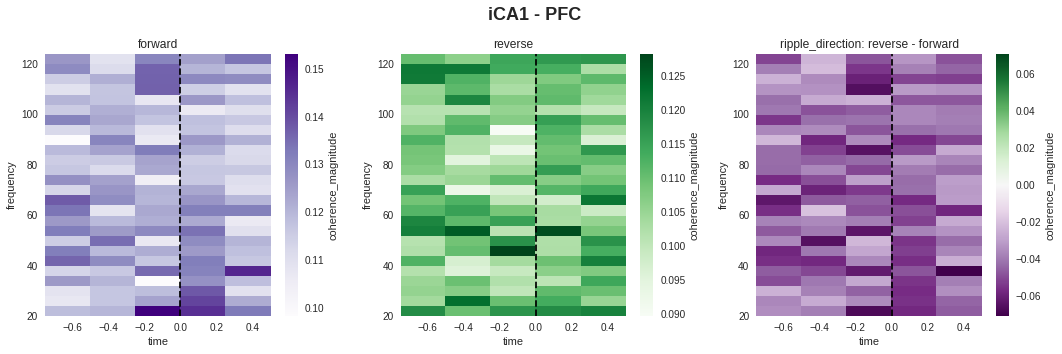

In [11]:
path = '../Processed-Data/*.nc'
covariate = 'ripple_direction'
level1 = 'forward'
level2 = 'reverse'
resolution = '4Hz_Resolution'
frequency = slice(20, 125)

brain_areas = ['CA1', 'iCA1', 'PFC']
for brain_area1, brain_area2 in combinations(brain_areas, 2):
    plot_coherence_by_ripple_type(path, brain_area1, brain_area2, frequency,
                                  resolution, covariate, level1, level2)

#### 10 Hz Frequency Resolution

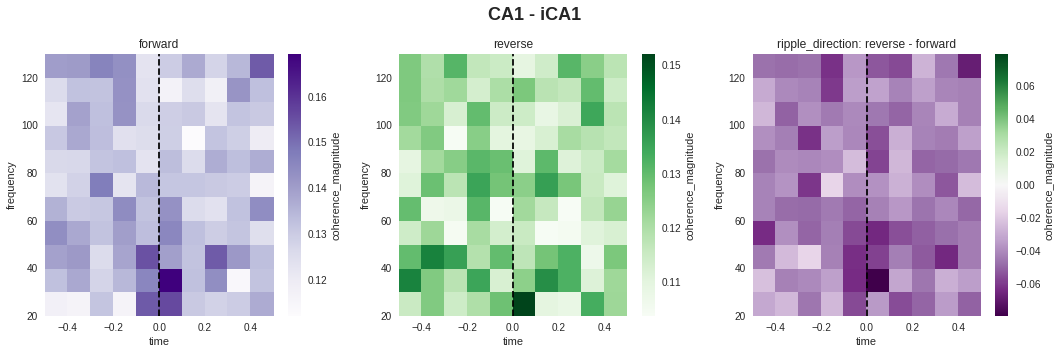

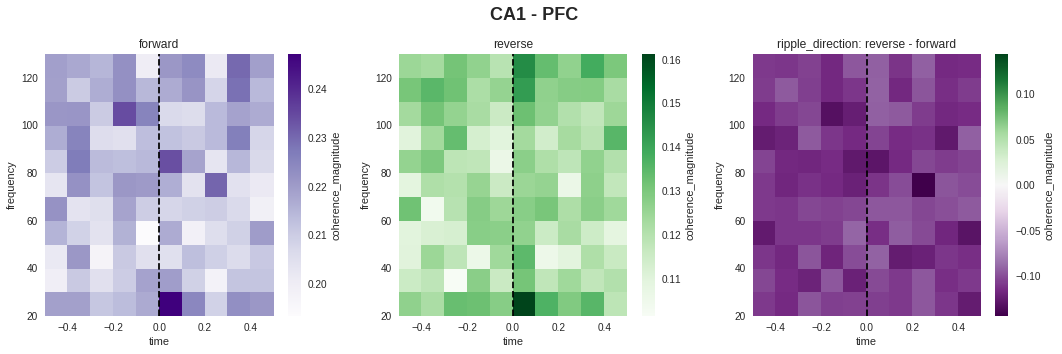

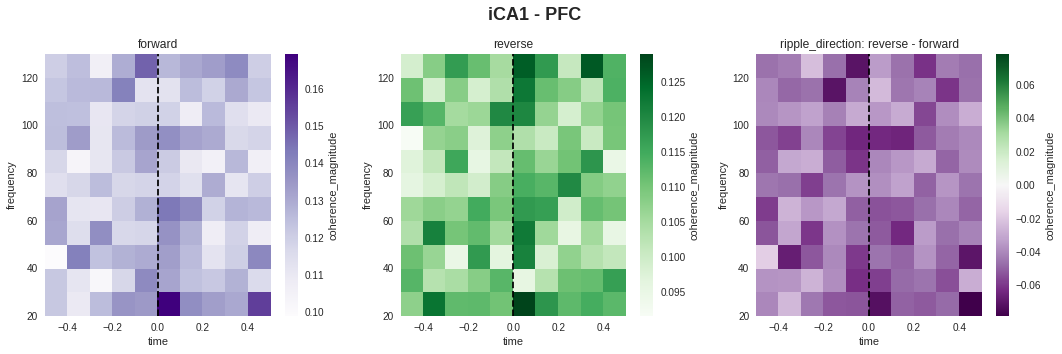

In [12]:
path = '../Processed-Data/*.nc'
covariate = 'ripple_direction'
level1 = 'forward'
level2 = 'reverse'
resolution = '10Hz_Resolution'
frequency = slice(20, 125)

brain_areas = ['CA1', 'iCA1', 'PFC']
for brain_area1, brain_area2 in combinations(brain_areas, 2):
    plot_coherence_by_ripple_type(path, brain_area1, brain_area2, frequency,
                                  resolution, covariate, level1, level2)

### Ripple Frequencies

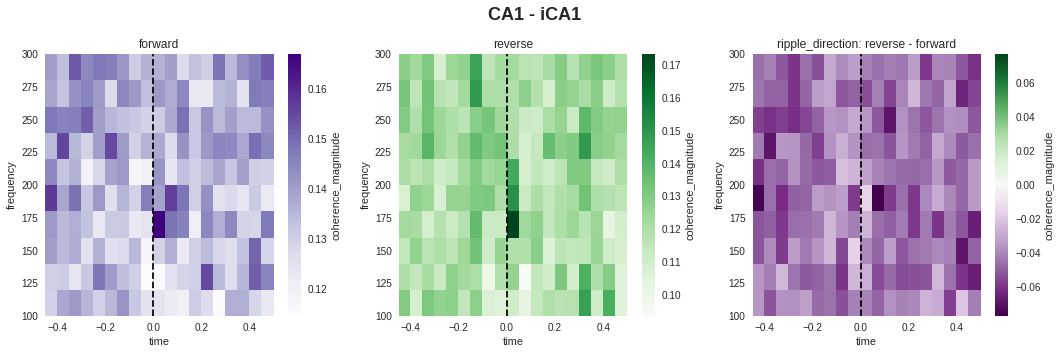

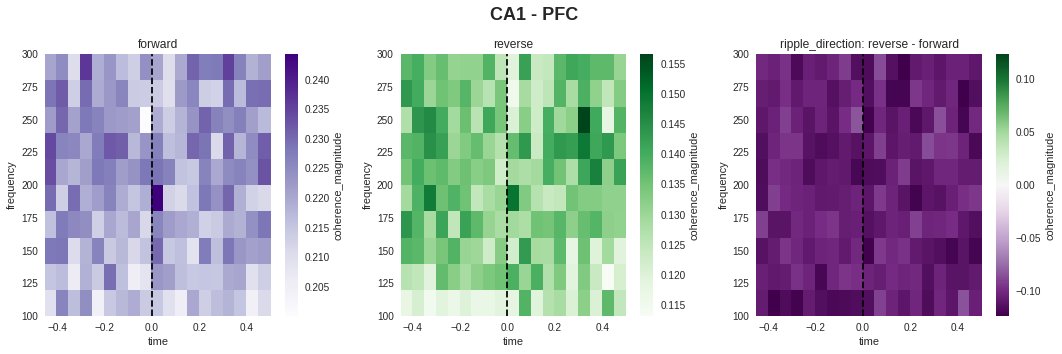

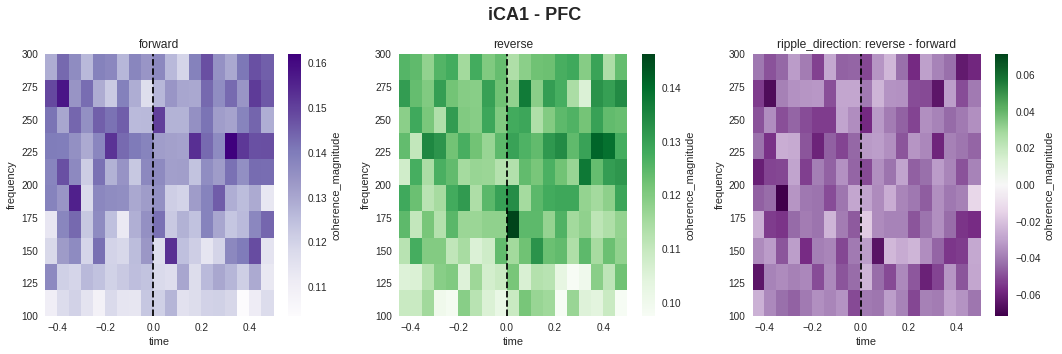

In [13]:
path = '../Processed-Data/*.nc'
covariate = 'ripple_direction'
level1 = 'forward'
level2 = 'reverse'
resolution = '20Hz_Resolution'
frequency = slice(100, 300)

brain_areas = ['CA1', 'iCA1', 'PFC']
for brain_area1, brain_area2 in combinations(brain_areas, 2):
    plot_coherence_by_ripple_type(path, brain_area1, brain_area2, frequency,
                                  resolution, covariate, level1, level2)

## Ripple Trajectory: Inbound vs. Outbound

### Low Frequencies

In [10]:
path = '../Processed-Data/*.nc'
covariate = 'ripple_trajectory'
level1 = 'inbound'
level2 = 'outbound'
resolution = '4Hz_Resolution'
frequency = slice(0, 30)

brain_areas = ['CA1', 'iCA1', 'PFC']
for brain_area1, brain_area2 in combinations(brain_areas, 2):
    plot_coherence_by_ripple_type(path, brain_area1, brain_area2, frequency,
                                  resolution, covariate, level1, level2)

OSError: [Errno group not found: outbound] 'outbound'

### Gamma Frequencies

#### 4 Hz Frequency Resolution

In [ ]:
path = '../Processed-Data/*.nc'
covariate = 'ripple_trajectory'
level1 = 'inbound'
level2 = 'outbound'
resolution = '4Hz_Resolution'
frequency = slice(20, 125)

brain_areas = ['CA1', 'iCA1', 'PFC']
for brain_area1, brain_area2 in combinations(brain_areas, 2):
    plot_coherence_by_ripple_type(path, brain_area1, brain_area2, frequency,
                                  resolution, covariate, level1, level2)

#### 10 Hz Frequency Resolution

In [ ]:
path = '../Processed-Data/*.nc'
covariate = 'ripple_trajectory'
level1 = 'inbound'
level2 = 'outbound'
resolution = '10Hz_Resolution'
frequency = slice(20, 125)

brain_areas = ['CA1', 'iCA1', 'PFC']
for brain_area1, brain_area2 in combinations(brain_areas, 2):
    plot_coherence_by_ripple_type(path, brain_area1, brain_area2, frequency,
                                  resolution, covariate, level1, level2)

### Ripple Frequencies

In [ ]:
path = '../Processed-Data/*.nc'
covariate = 'ripple_trajectory'
level1 = 'inbound'
level2 = 'outbound'
resolution = '20Hz_Resolution'
frequency = slice(100, 300)

brain_areas = ['CA1', 'iCA1', 'PFC']
for brain_area1, brain_area2 in combinations(brain_areas, 2):
    plot_coherence_by_ripple_type(path, brain_area1, brain_area2, frequency,
                                  resolution, covariate, level1, level2)